# Logistic Regression
##### Gabriel Briones Sayeg A01222517

#### Import libraries to be used

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import scipy.stats as stat
from pandas import read_csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

#### Load and clean data.
The dataset contains 16 missing data in "Bare Nuclei" field, they will be replaced with the mean integer: "3".
Also, the "Sample code" field is being removed as it is not part of the analytics.
The "Class" field showing data as 2 or 4 will be replaced with 0 and I respectively. Then this problem can be considered as a binary classification and we can consider one of the algorithms for such case.

In [2]:
bcw_data = read_csv('breast-cancer-wisconsin.data', header=None)
bcw_data.columns = ['Sample code', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape',
                'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
                'Normal Nucleoli', 'Mitoses','Class']
bcw_data = bcw_data.replace('?', np.NaN)
bcw_data['Bare Nuclei'].fillna((pd.to_numeric(bcw_data['Bare Nuclei']).median()), inplace=True)
bcw_data['Bare Nuclei'] = bcw_data['Bare Nuclei'].astype('int64')
bcw_data['Class'] = bcw_data['Class'].replace(2, 0).replace(4, 1)
x = bcw_data.iloc[:,1:10]
y = bcw_data.iloc[:,10]

#### Analyze data

One of the used methods is the Pearson correlation which indicates how fields correlate with each other, with 1.0 meaning values are exactly the same.
It is displayed the correlation for the class field and we can see that the "Mitoses" field is not very descriptive. On the other hand the fields "Uniformity of Cell Size" and "Uniformity of Cell Shape" show the best correlation with the class.

In [3]:
data = bcw_data.iloc[:,1:]
data.corr(method="pearson").Class

Clump Thickness                0.716001
Uniformity of Cell Size        0.817904
Uniformity of Cell Shape       0.818934
Marginal Adhesion              0.696800
Single Epithelial Cell Size    0.682785
Bare Nuclei                    0.818968
Bland Chromatin                0.756616
Normal Nucleoli                0.712244
Mitoses                        0.423170
Class                          1.000000
Name: Class, dtype: float64

Next it is displayed the box diagrams for each field. We can see the data in the "Mitoses" field is very disperse and wont be significant to be included in our training model.

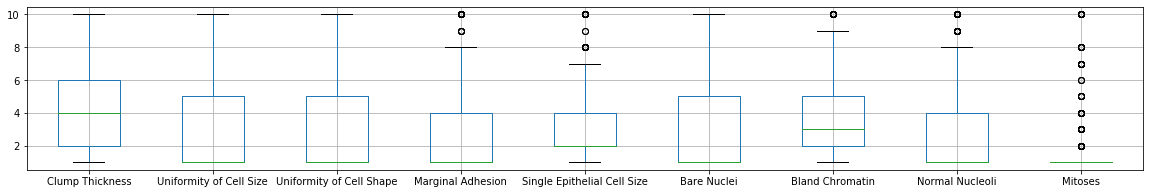

In [4]:
x.boxplot(figsize=(20,3))
plt.show()

Then, it is shown the relation between the attributes and the Class to display the logistic distribution.

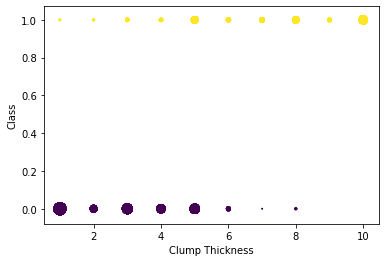

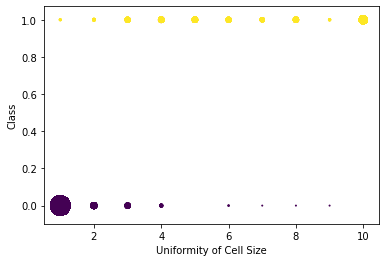

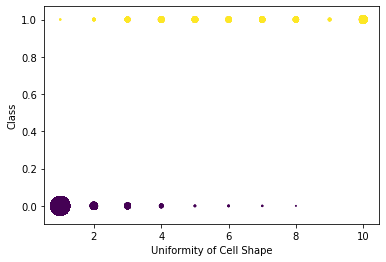

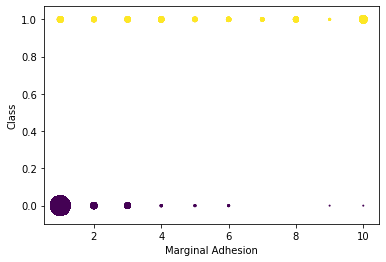

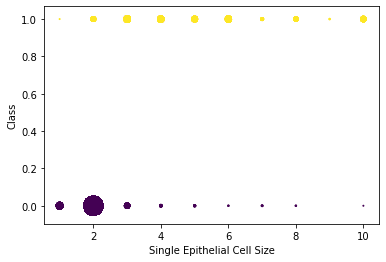

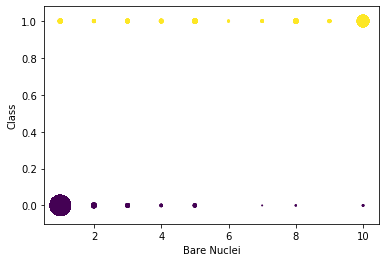

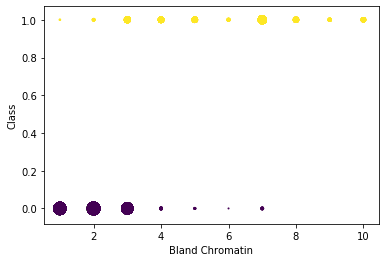

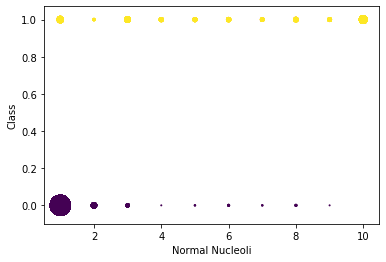

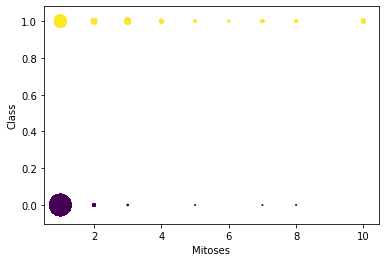

In [5]:
data = bcw_data.copy()
for field in list(data.iloc[:, 1:10]):
    data['Count'] = 0
    for i, _ in data.iterrows():
        data.loc[i, 'Count'] += len(data[(data[field] == data.loc[i, field]) & (data['Class'] == data.loc[i, 'Class'])])
    plt.scatter(data[field], data['Class'], c=data["Class"], s=data['Count'])
    plt.xlabel(field)
    plt.ylabel('Class')
    plt.show()


#### Attribute analisys

After analyzing the data, it is concluded that the variables 1 to 9 are going to be used as input variables considering them as numerical values requireing normalization. The field "Class" is the output variable considered as a binary value turned on when is malignant.

#### Data splitting

The data is divided into training data and testing data in a proportion of 80% and 20% of the whole dataset respectively. Nevertheless, there are significant more "benign" records than "malignant" which requires stratified selection of test data.

In [6]:
# Split by class
b_data = bcw_data[bcw_data['Class'] == 0]
m_data = bcw_data[bcw_data['Class'] == 1]

# Split benign data into train and test
b_split = int(len(b_data)*.8)
b_data_train = b_data[:b_split]
b_data_test = b_data[b_split:]

# Split malignant into train and test
m_split = int(len(m_data)*.8)
m_data_train = m_data[:m_split]
m_data_test = m_data[m_split:]

# Join benign and malignant data into train and test
data_train = pd.concat((b_data_train, m_data_train))
data_test = pd.concat((b_data_test, m_data_test))

# Split into X and y
X_test = data_test.iloc[:, 1:9]
y_test = data_test.iloc[:, 10]
X_train = data_train.iloc[:, 1:9]
y_train = data_train.iloc[:, 10]

#### Training the model

To generate the model it is being used a Logistic regression algorithm which is used for binary classification problems. 

It is also being displayed the confusion matrix, the accuaracy of the model and the p-values.

In [7]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_proba = classifier.predict_proba(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("Accuaracy:", classifier.score(X_train, y_train))

def get_pvalues(classifier, X):
    X = X_train.copy()
    denom = (2.0*(1.0+np.cosh(classifier.decision_function(X))))
    denom = np.tile(denom,(X.shape[1],1)).T
    F_ij = np.dot((X/denom).T,X)
    Cramer_Rao = np.linalg.inv(F_ij)
    sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
    z_scores = classifier.coef_[0]/sigma_estimates
    return [stat.norm.sf(abs(x))*2 for x in z_scores]
    
print("P-values: \n", get_pvalues(classifier, X_train))

Confusion Matrix:
 [[92  0]
 [ 2 47]]
Accuaracy: 0.9605734767025089
P-values: 
 [4.2849589280493457e-05, 0.552488711268116, 0.06899994209440084, 0.340933108260028, 0.8628004571831277, 6.261534142408193e-07, 0.4791860028959599, 0.1082587323405178]


#### Cross validation

Reapeat the same training of the model with different splits of the data

In [8]:
for i in range(5):
    print("Cross Validation Segment {}".format(i+1))
    
    # Split benign data
    b_start = int(len(b_data)*((i*2)/10))
    b_end = int(len(b_data)*(((i+1)*2)/10))
    b_data_test = b_data[b_start:b_end]
    b_data_train = pd.concat([b_data[:b_start],b_data[b_end:]])
    
    # Split malignant data
    m_start = int(len(m_data)*((i*2)/10))
    m_end = int(len(m_data)*(((i+1)*2)/10))
    m_data_test = m_data[m_start:m_end]
    m_data_train = pd.concat([m_data[:m_start], m_data[m_end:]])
    
    # Join benign and malignant data
    data_train = pd.concat((b_data_train, m_data_train))
    data_test = pd.concat((b_data_test, m_data_test))
    
    # Sepparate into X and y
    X_test = data_test.iloc[:, 1:9]
    y_test = data_test.iloc[:, 10]
    X_train = data_train.iloc[:, 1:9]
    y_train = data_train.iloc[:, 10]
    
    # Train model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    print("Confusion Matrix:\n", cm)
    print("Accuaracy:", model.score(X_train, y_train))
    print("P-values: \n", get_pvalues(model, X_train))
    print()

Cross Validation Segment 1
Confusion Matrix:
 [[88  3]
 [ 7 41]]
Accuaracy: 0.9732142857142857
P-values: 
 [0.13306647585474227, 0.0535014587742697, 0.31661400839978227, 0.08605693658299488, 0.15885704085236618, 7.301330126217708e-07, 0.49764508977895483, 0.12709382590947008]

Cross Validation Segment 2
Confusion Matrix:
 [[85  7]
 [ 2 46]]
Accuaracy: 0.9785330948121646
P-values: 
 [0.0009557235957767087, 0.3050400821318341, 0.16666055085602294, 0.27997095995774746, 0.4707377333050128, 2.3850074379028216e-05, 0.09105461925378677, 0.01406637279482716]

Cross Validation Segment 3
Confusion Matrix:
 [[90  1]
 [ 0 48]]
Accuaracy: 0.9607142857142857
P-values: 
 [0.0019114938957069821, 0.05287039753290263, 0.15312840226802357, 0.2907568815079259, 0.6153890271108613, 4.541322127769908e-06, 0.35905903245480886, 0.32830009984814235]

Cross Validation Segment 4
Confusion Matrix:
 [[92  0]
 [ 2 46]]
Accuaracy: 0.9588550983899821
P-values: 
 [0.0002304236819183491, 0.24259029894081685, 0.196187056

#### Conclusions

The model appears to be very accurate, as the results thrown by the tests are very reliable.